In [21]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import backtrader as bt
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


Load & align data

In [4]:
price_path   = r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'
vader_path   = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_vader_sentiment_v2.csv'
finbert_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_finbert_sentiment_v4.csv'

In [5]:
price = (pd.read_csv(price_path,   parse_dates=['date'], low_memory=False)
         .set_index('date')
         .loc['2020-12-31':'2024-12-31', 'close'])

In [6]:
vader = (pd.read_csv(vader_path,   parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_vader_sentiment'])

In [7]:
finbert = (pd.read_csv(finbert_path, parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_finbert_score'])

In [8]:
df = pd.concat({'close': price, 'vader': vader, 'finbert': finbert}, axis=1).dropna()

In [9]:
df['ret'] = np.log(df['close']).diff()
df = df.dropna()

In [10]:
display(df)

,close,vader,finbert,ret
date,,,,
2021-01-02,32127.267600,0.211708,-0.095451,0.089590
2021-01-03,32782.023400,0.235294,-0.089225,0.020175
2021-01-04,31971.914100,0.218767,-0.122876,-0.025022
2021-01-05,33992.429700,0.230068,-0.102810,0.061280
2021-01-06,36824.363300,0.216308,-0.063119,0.080022
...,...,...,...,...
2024-12-27,94164.860348,0.194715,-0.176657,-0.017169
2024-12-28,95163.931926,0.242571,-0.153984,0.010554
2024-12-29,93530.228438,0.189678,-0.174026,-0.017316


Build the signal

In [11]:
EMA_SPAN = 5      # smoothing window
ROLL_Z = 90     # rolling z-score window

- Uses only past 90 days for the mean/std → no data leakage.
- Equal-weight average after standardisation gives each model equal influence.
- Outliers capped to ±3σ so a single Reddit outlier won’t compromise the allocation.

“To combine VADER and FinBERT scores, each series is transformed into a 90-day rolling z-score to eliminate scale and mean differences. The two normalised series are then averaged to form a composite sentiment index. Extreme values beyond ±3 σ are capped to reduce the impact of rare Reddit-driven sentiment spikes. Finally, a span-5 exponential moving average (half-life ≈ 2.8 days) smooths day-to-day noise while preserving the short-term predictive signal identified in Section 4.2.”

In [12]:
# rolling standardisation (finbert and vader do not have the same scale)
roll_mean_v = vader.rolling(ROLL_Z).mean()
roll_std_v  = vader.rolling(ROLL_Z).std()

roll_mean_f = finbert.rolling(ROLL_Z).mean()
roll_std_f  = finbert.rolling(ROLL_Z).std()

df['vader_z']   = (df['vader']   - roll_mean_v) / roll_std_v
df['finbert_z'] = (df['finbert'] - roll_mean_f) / roll_std_f

In [13]:
# composite sentiment
df['sent_raw'] = df[['vader_z', 'finbert_z']].mean(axis=1)

# optional: Winsorise extreme z-scores to +/- 3 to tame outliers
df['sent_raw'] = df['sent_raw'].clip(lower=-3, upper=3)

# smoothing
df['sent_ema'] = df['sent_raw'].ewm(span=EMA_SPAN, adjust=False).mean()

In [14]:
df[['vader_z', 'finbert_z', 'sent_raw']].describe()

,vader_z,finbert_z,sent_raw
count,1372.000000,1372.000000,1372.000000
mean,-0.021347,-0.022083,-0.023282
std,1.061312,1.054883,0.934133
min,-4.720014,-3.094124,-3.000000
25%,-0.679890,-0.804048,-0.655746
50%,0.028530,-0.037667,-0.005755
75%,0.689570,0.672782,0.622120
max,7.239749,5.019495,3.000000


We roll 60 days to obtain 75th/25th percentiles (no look-ahead bias)
and test EMA spans 3–10 on 2021-23 (in-sample).  The best span is then
frozen for 2024 (out-of-sample).

In [15]:
# params
TRAIN_END   = '2023-12-31'     # IS / OOS split
ROLL_PCT    = 60               # window for percentile thresholds
TH_UP, TH_DN = 0.75, 0.25      # 75th / 25th percentiles
TC          = 0.001            # 0.10 % round-trip cost
EMA_GRID    = range(3, 11)     # spans to test (3…10)


In [16]:
# Helper functions
SHARPE_DAYS = 365          # leave 365 for crypto; convert later if needed

def ann_sharpe(ret: pd.Series) -> float:
    return np.sqrt(SHARPE_DAYS) * ret.mean() / ret.std()

def cum_curve(ret: pd.Series) -> pd.Series:
    """Cumulative growth of 1 unit."""
    return np.exp(ret.cumsum())

def max_drawdown(ret: pd.Series) -> float:
    r   = ret.fillna(0)            # ← ①  replace first NaN by 0-return
    eq  = np.exp(r.cumsum())       # cumulative equity
    roll_max = np.maximum.accumulate(eq)
    dd  = 1 - eq / roll_max
    return dd.max()                # ← ②  now a valid float


In [17]:
# strategy function
def build_strategy(df_in: pd.DataFrame, ema_span: int,
                   return_alloc: bool = False):
    """
    Build Strategy A and return daily returns
    """
    d = df_in.copy()

    # 1) Smooth sentiment
    d['sent_ema'] = d['sent_raw'].ewm(span=ema_span, adjust=False).mean()

    # 2) Adaptive thresholds
    p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_UP)
    p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_DN)

    # 3) Regime classification → allocation
    d['regime'] = np.where(d['sent_ema'] > p75, 'bull',
                           np.where(d['sent_ema'] < p25, 'bear', 'neutral'))
    alloc_map = {'bull': 1.0, 'neutral': 0.60, 'bear': 0.0}
    d['alloc_daily'] = d['regime'].map(alloc_map)

    # 4) Weekly rebal (Monday close)
    d['alloc'] = (d['alloc_daily']
                  .resample('W-MON')
                  .first()
                  .reindex(d.index, method='ffill'))

    # 5) Strategy returns with TC
    alloc_prev = d['alloc'].shift()
    tc = np.abs(d['alloc'] - alloc_prev) * TC
    strat_ret = alloc_prev * d['ret'] - tc.fillna(0)

    if return_alloc:
        return strat_ret, d['alloc']
    return strat_ret

Best EMA span (IS 2021-23) = 8   |  Sharpe = 0.18

=== Quick performance check ===
IS  Sharpe: 0.18
OOS Sharpe: 1.96


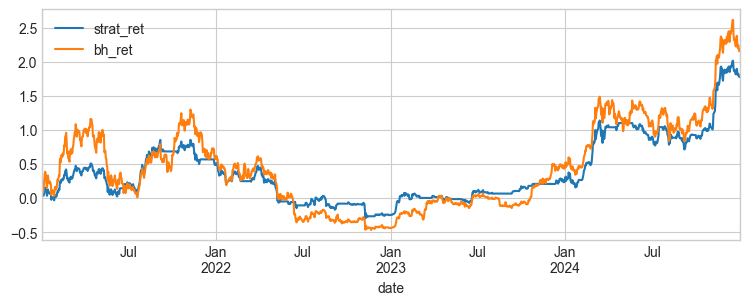

In [18]:
is_mask = df.index <= TRAIN_END
grid_results: List[Tuple[int, float]] = []

for span in EMA_GRID:
    r   = build_strategy(df, span)
    sh  = ann_sharpe(r[is_mask])
    grid_results.append((span, sh))

best_span, best_sh    = max(grid_results, key=lambda x: x[1])
print(f'Best EMA span (IS 2021-23) = {best_span}   |  Sharpe = {best_sh:.2f}')

# --------------------  B)  FULL RUN WITH FROZEN SPAN -------------
df['strat_ret'] = build_strategy(df, best_span)
df['bh_ret']    = df['ret']                     # buy-and-hold benchmark

oos_mask        = df.index > TRAIN_END

print('\n=== Quick performance check ===')
print('IS  Sharpe:', ann_sharpe(df['strat_ret'][is_mask]).round(2))
print('OOS Sharpe:', ann_sharpe(df['strat_ret'][oos_mask]).round(2))

# optional quick look at cumulative performance
(np.exp(df[['strat_ret','bh_ret']].cumsum()) - 1).plot(figsize=(9,3));

Full                IS               OOS         
          Strategy Buy&Hold Strategy Buy&Hold Strategy Buy&Hold
Total Ret     2.78     3.18     1.24     1.44     2.24     2.21
Ann Vol       0.40     0.62     0.40     0.65     0.41     0.53
Sharpe        0.63     0.47     0.18     0.19     1.96     1.49
Max DD        0.62     0.77     0.62     0.77     0.20     0.26

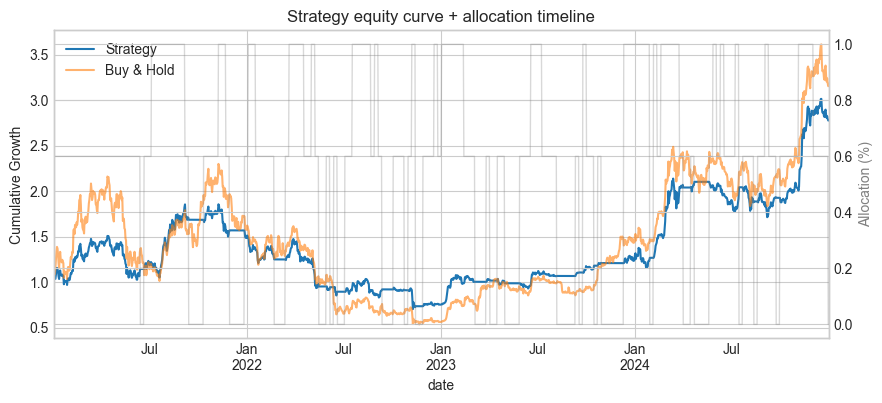

In [19]:
# rebuild with frozen best_span AND capture allocation timeline
df['strat_ret'], df['alloc'] = build_strategy(df, best_span, return_alloc=True)
df['bh_ret'] = df['ret']

# performance table
def stats(label, r):
    return pd.Series({
        'Total Ret': cum_curve(r).iloc[-1],
        'Ann Vol': r.std()*np.sqrt(SHARPE_DAYS),
        'Sharpe': ann_sharpe(r),
        'Max DD': max_drawdown(r)
    }, name=label)

is_mask  = df.index <= TRAIN_END
oos_mask = df.index >  TRAIN_END

table = pd.concat({
    'Full':  pd.concat([stats('Strategy', df['strat_ret']),
                        stats('Buy&Hold', df['bh_ret'])], axis=1),
    'IS':    pd.concat([stats('Strategy', df.loc[is_mask, 'strat_ret']),
                        stats('Buy&Hold', df.loc[is_mask, 'bh_ret'])], axis=1),
    'OOS':   pd.concat([stats('Strategy', df.loc[oos_mask, 'strat_ret']),
                        stats('Buy&Hold', df.loc[oos_mask, 'bh_ret'])], axis=1)
}, axis=1).round(2)

display(table)     # nice in Jupyter

# equity + alloc overlay
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,4))
cum_curve(df['strat_ret']).plot(ax=ax1, label='Strategy')
cum_curve(df['bh_ret']).plot(ax=ax1, label='Buy & Hold', alpha=.6)
ax1.set_ylabel('Cumulative Growth')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
df['alloc'].plot(ax=ax2, color='grey', alpha=.3, linewidth=1)
ax2.set_ylabel('Allocation (%)', color='grey')
ax2.set_ylim(-0.05,1.05)
plt.title('Strategy equity curve + allocation timeline')
plt.show()


Initial capital (1 Jan 2024):  $10,000
Buy-and-Hold final (31 Dec 2024): $21,153
Strategy A  final (31 Dec 2024): $22,395


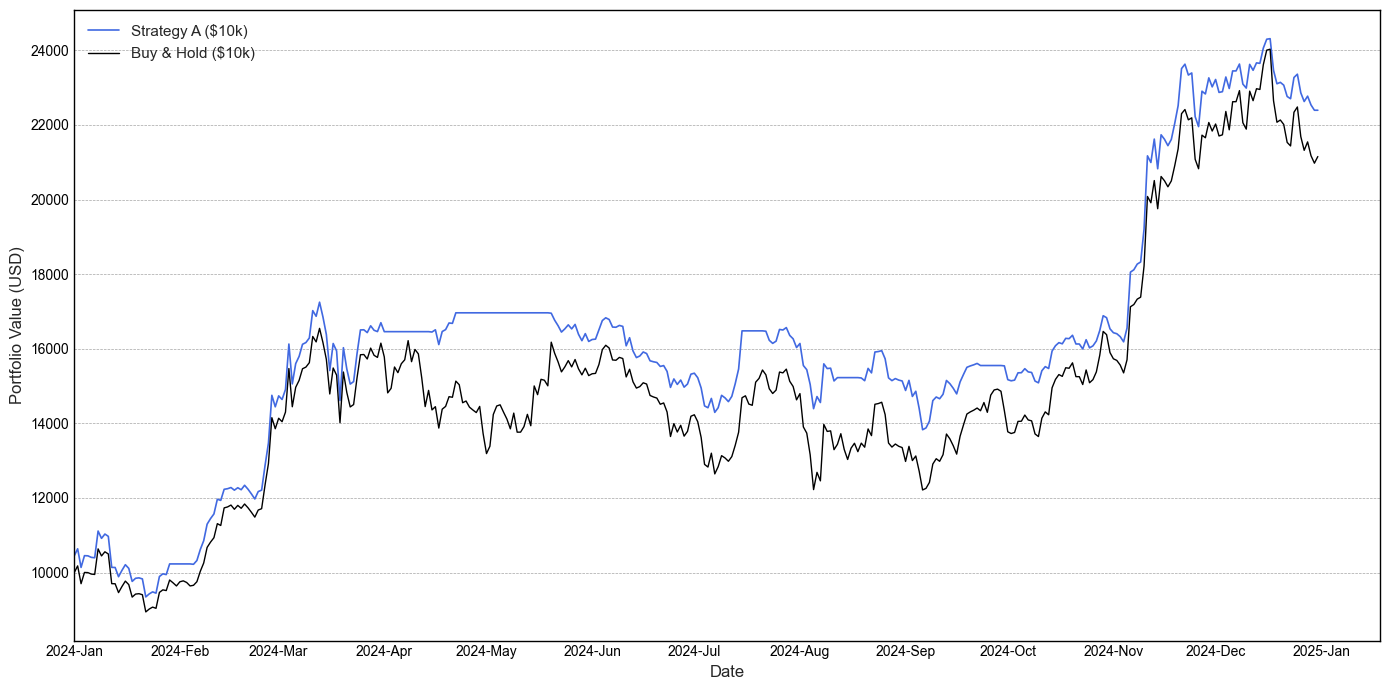

In [24]:
plt.style.use('seaborn-v0_8-whitegrid')

start_date      = '2024-01-01'
initial_capital = 10_000

# ── 1. Align dataframe to the chosen start date ─────────────────
sub = df.loc[start_date:].copy()

# ensure no NaNs propagate
sub['strat_ret'] = sub['strat_ret'].fillna(0)

# keep only rows where both close-price and strat_ret are present
sub = sub.dropna(subset=['close', 'strat_ret'])

# ── 2. Build equity curves ─────────────────────────────────────
bh_equity    = initial_capital * sub['close'] / sub['close'].iloc[0]
strat_equity = initial_capital * np.exp(sub['strat_ret'].cumsum())

# print start / end values
print(f"\nInitial capital (1 Jan 2024):  ${initial_capital:,.0f}")
print(f"Buy-and-Hold final (31 Dec 2024): ${bh_equity.iloc[-1]:,.0f}")
print(f"Strategy A  final (31 Dec 2024): ${strat_equity.iloc[-1]:,.0f}")

# ── 3. Plot ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(sub.index, strat_equity, color='royalblue', linewidth=1.2,
        label='Strategy A ($10k)')
ax.plot(sub.index, bh_equity,    color='black',     linewidth=1.0,
        label='Buy & Hold ($10k)')

ax.set_xlim(left=pd.to_datetime(start_date))
ax.set_xlabel('Date',  fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)

# axis styling
for spine in ('top', 'right', 'left', 'bottom'):
    ax.spines[spine].set_color('black')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

ax.grid(True,  which='major', axis='y', linestyle='--',
        linewidth=0.5, color='grey', alpha=0.7)
ax.grid(False, which='major', axis='x')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
print(bh_equity.tail(10))


Initial capital (2021-01-01):  $10,000
Buy-and-Hold final (2023-12-31): $13,156
Strategy A  final (2023-12-31): $12,401


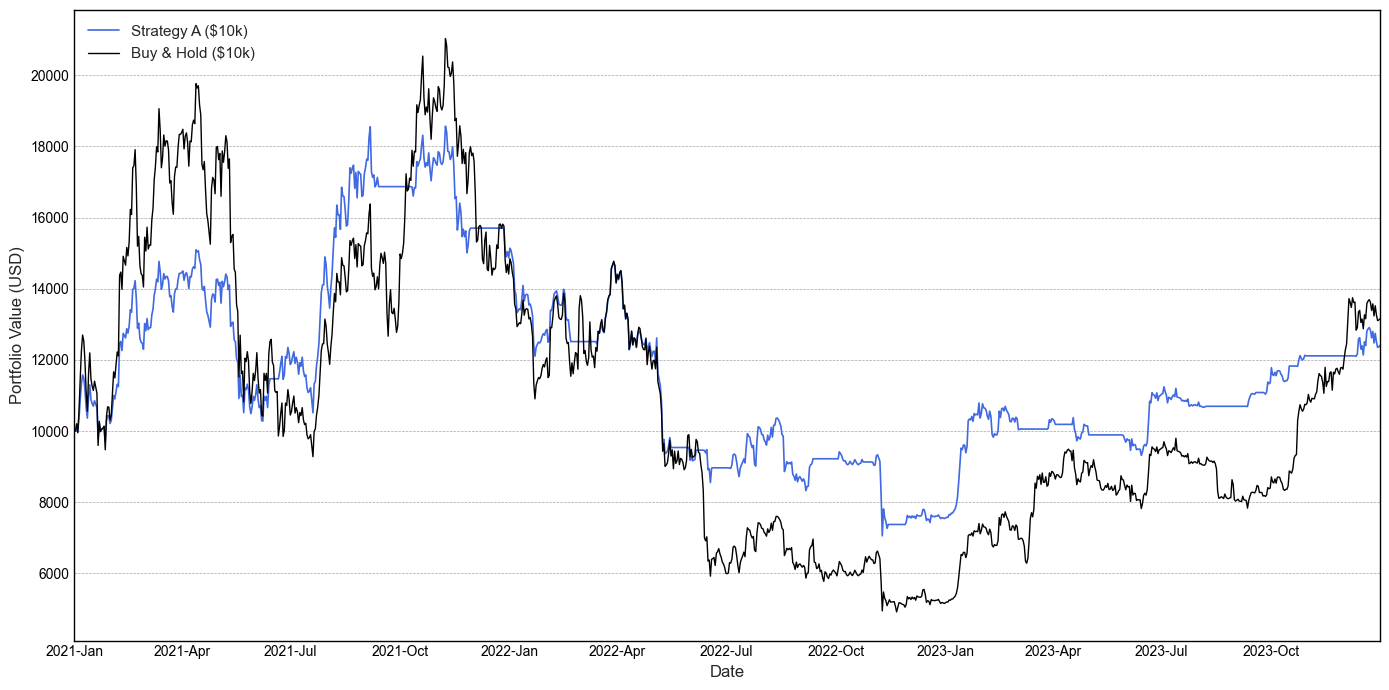

In [25]:
start_date = '2021-01-01'
end_date   = '2023-12-31'
initial_capital = 10_000

# ── 1. Slice dataframe to the IS window ─────────────────────────
sub = df.loc[start_date:end_date].copy()

# handle first-row NaN from shift()
sub['strat_ret'] = sub['strat_ret'].fillna(0)

# keep rows where both series are present
sub = sub.dropna(subset=['close', 'strat_ret'])

# ── 2. Equity curves ────────────────────────────────────────────
bh_equity    = initial_capital * sub['close'] / sub['close'].iloc[0]
strat_equity = initial_capital * np.exp(sub['strat_ret'].cumsum())

# print start / end values
print(f"\nInitial capital ({start_date}):  ${initial_capital:,.0f}")
print(f"Buy-and-Hold final ({end_date}): ${bh_equity.iloc[-1]:,.0f}")
print(f"Strategy A  final ({end_date}): ${strat_equity.iloc[-1]:,.0f}")

# ── 3. Plot ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(sub.index, strat_equity, color='royalblue', linewidth=1.2,
        label='Strategy A ($10k)')
ax.plot(sub.index, bh_equity,    color='black',     linewidth=1.0,
        label='Buy & Hold ($10k)')

ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
ax.set_xlabel('Date',  fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)

# axis styling
for spine in ('top', 'right', 'left', 'bottom'):
    ax.spines[spine].set_color('black')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

ax.grid(True,  which='major', axis='y', linestyle='--',
        linewidth=0.5, color='grey', alpha=0.7)
ax.grid(False, which='major', axis='x')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()


Initial capital (2024-01-01):      $10,000
Strategy A final (2024-12-31):        $21,431
BTC Buy&Hold final (2024-12-31):      $20,781
S&P500 Buy&Hold final (2024-12-31):   $12,401


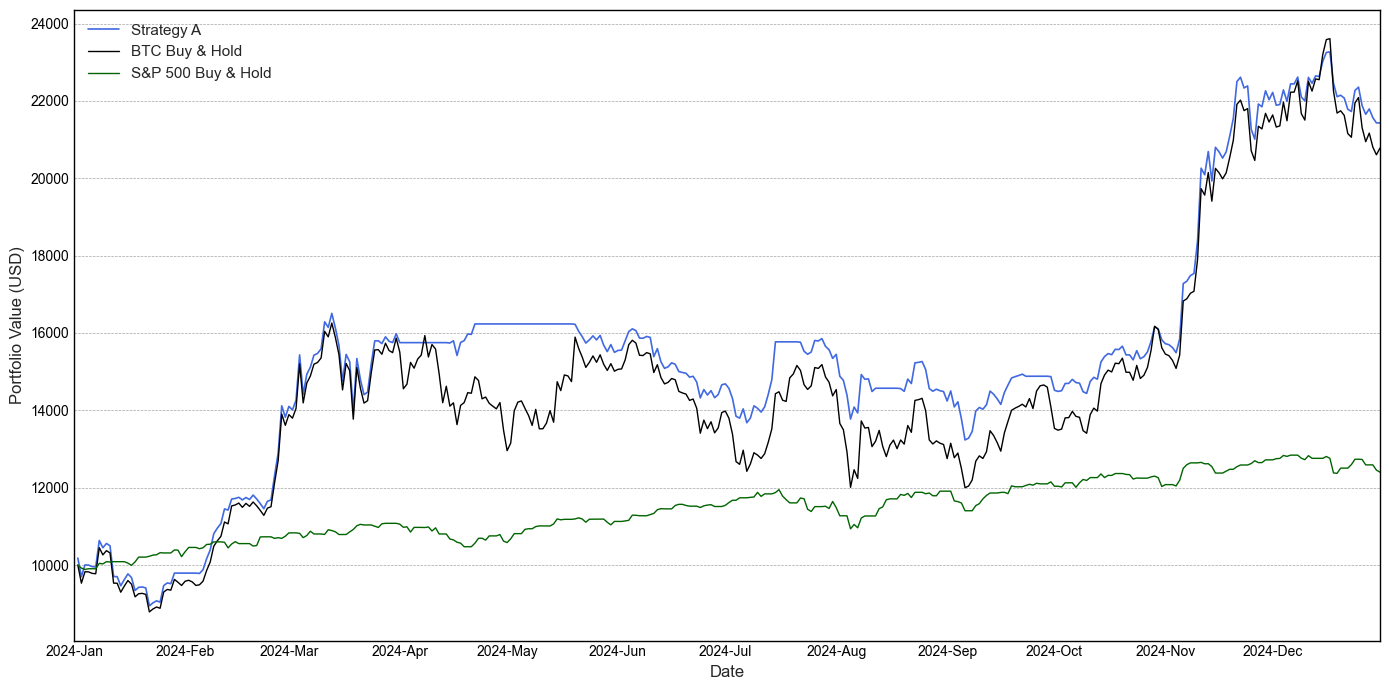

In [26]:
plt.style.use('seaborn-v0_8-whitegrid')

# ---- path to S&P 500 CSV ----
spx_path = r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\sp500_2020_2025.csv'

# ---- pick the window you want ----
start_date = '2024-01-01'  # '2021-01-01' for IS, '2024-01-01' for OOS
end_date = '2024-12-31'  # keep or adjust
initial_capital = 10_000

# --------------------------------------------------------------
# 1. Load S&P500 (date, close) and align to BTC date index
# --------------------------------------------------------------
spx = (pd.read_csv(spx_path, parse_dates=['date'], usecols=['date', 'close'])
       .set_index('date')
       .rename(columns={'close': 'spx_close'}))

# subset master df to chosen window and make a copy
sub = df.loc[start_date:end_date].copy()
sub['strat_ret'] = sub['strat_ret'].fillna(0)

# merge S&P; forward-fill weekends so index aligns
sub = sub.join(spx, how='left').ffill()  # ffill handles weekends

# drop any row that still has NaNs in critical columns
sub = sub.dropna(subset=['close', 'strat_ret', 'spx_close'])

# --------------------------------------------------------------
# 2. Build equity curves
# --------------------------------------------------------------
bh_btc = initial_capital * sub['close'] / sub['close'].iloc[0]
bh_spx = initial_capital * sub['spx_close'] / sub['spx_close'].iloc[0]
eq_strat = initial_capital * np.exp(sub['strat_ret'].cumsum())

# print final values
print(f"\nInitial capital ({start_date}):      ${initial_capital:,.0f}")
print(f"Strategy A final ({end_date}):        ${eq_strat.iloc[-1]:,.0f}")
print(f"BTC Buy&Hold final ({end_date}):      ${bh_btc.iloc[-1]:,.0f}")
print(f"S&P500 Buy&Hold final ({end_date}):   ${bh_spx.iloc[-1]:,.0f}")

# --------------------------------------------------------------
# 3. Plot
# --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(sub.index, eq_strat, color='royalblue', linewidth=1.2, label='Strategy A')
ax.plot(sub.index, bh_btc, color='black', linewidth=1.0, label='BTC Buy & Hold')
ax.plot(sub.index, bh_spx, color='darkgreen', linewidth=1.0, label='S&P 500 Buy & Hold')

ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)

for spine in ('top', 'right', 'left', 'bottom'):
    ax.spines[spine].set_color('black')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
ax.grid(False, which='major', axis='x')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

ax.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()


C:\Users\Leo Hubmann\AppData\Local\Temp\ipykernel_31480\1736788261.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dca_dates = sub.resample(dca_freq).first().index



Initial capital budget (2024):          $10,000
Strategy A final (31 Dec 24):           $21,431
BTC Buy-and-Hold final:                 $20,781
S&P 500 Buy-and-Hold final:             $12,401
BTC DCA final (M):             $14,376  [12 contributions of $833]


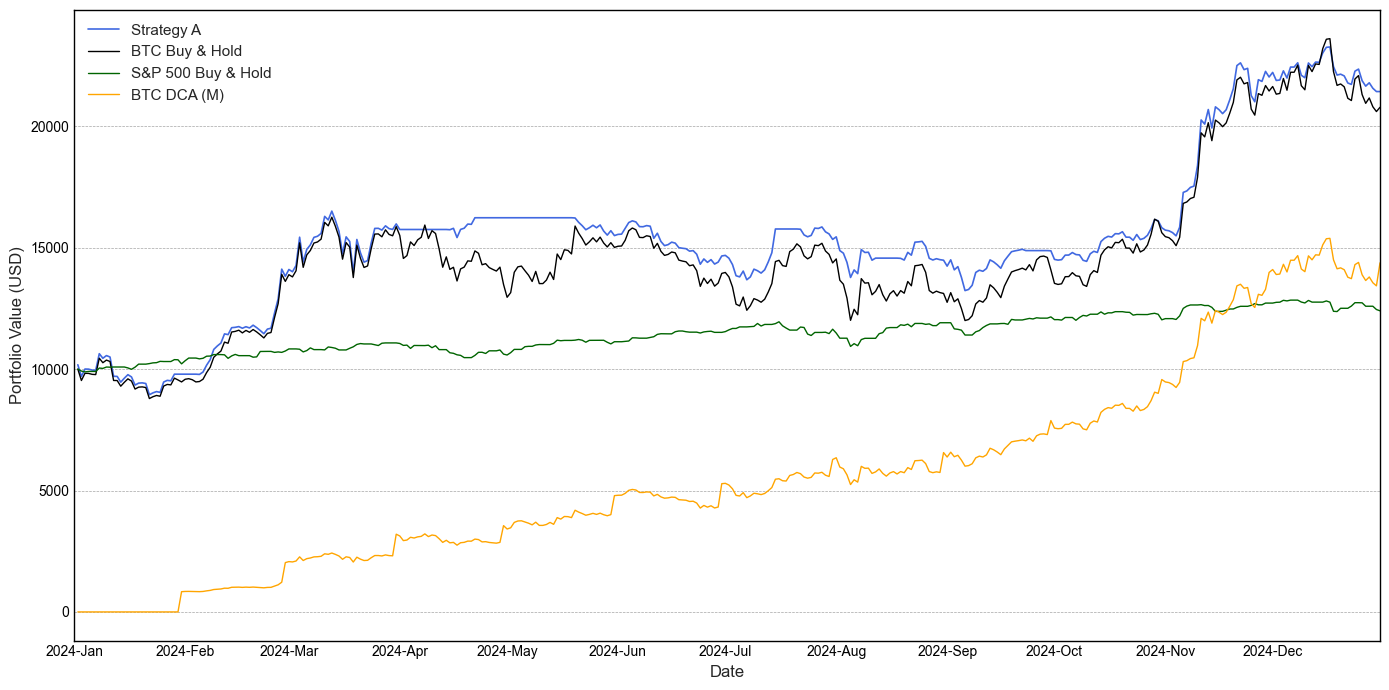

In [29]:
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import pandas as pd, numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

# -------------- PARAMETERS ---------------------------------------------------
start_date = '2024-01-01'
end_date = '2024-12-31'
initial_capital_total = 10_000  # total capital for B&H and total budget for DCA
dca_freq = 'M'  # 'W-MON' = every Monday; use 'M' for monthly, 'D' for daily
# -----------------------------------------------------------------------------

# 1) Slice master df and merge S&P 500
sub = df.loc[start_date:end_date].copy()
sub['strat_ret'] = sub['strat_ret'].fillna(0)

spx = (pd.read_csv(r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\sp500_2020_2025.csv',
                   parse_dates=['date'], usecols=['date', 'close'])
       .set_index('date')
       .rename(columns={'close': 'spx_close'}))

sub = sub.join(spx, how='left').ffill()
sub = sub.dropna(subset=['close', 'strat_ret', 'spx_close'])

# 2) Equity curves for Strategy A & Buy-and-Hold benchmarks
bh_btc = initial_capital_total * sub['close'] / sub['close'].iloc[0]
bh_spx = initial_capital_total * sub['spx_close'] / sub['spx_close'].iloc[0]
eq_strat = initial_capital_total * np.exp(sub['strat_ret'].cumsum())

# 3) DCA logic: equal contribution each rebalance date
dca_dates = sub.resample(dca_freq).first().index
n_contrib = len(dca_dates)
contrib = initial_capital_total / n_contrib

units_held = 0.0
equity_dca = []

for date in sub.index:
    if date in dca_dates:
        units_held += contrib / sub.at[date, 'close']
    equity_dca.append(units_held * sub.at[date, 'close'])

equity_dca = pd.Series(equity_dca, index=sub.index, name='DCA_BTC')

# ------------ Print ending values -------------------------------------------
print(f"\nInitial capital budget (2024):          ${initial_capital_total:,.0f}")
print(f"Strategy A final (31 Dec 24):           ${eq_strat.iloc[-1]:,.0f}")
print(f"BTC Buy-and-Hold final:                 ${bh_btc.iloc[-1]:,.0f}")
print(f"S&P 500 Buy-and-Hold final:             ${bh_spx.iloc[-1]:,.0f}")
print(f"BTC DCA final ({dca_freq}):             ${equity_dca.iloc[-1]:,.0f}  "
      f"[{n_contrib} contributions of ${contrib:,.0f}]")

# 4) Plot all four curves -----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(sub.index, eq_strat, color='royalblue', linewidth=1.2, label='Strategy A')
ax.plot(sub.index, bh_btc, color='black', linewidth=1.0, label='BTC Buy & Hold')
ax.plot(sub.index, bh_spx, color='darkgreen', linewidth=1.0, label='S&P 500 Buy & Hold')
ax.plot(sub.index, equity_dca, color='orange', linewidth=1.0, label=f'BTC DCA ({dca_freq})')

ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)

for spine in ('top', 'right', 'left', 'bottom'):
    ax.spines[spine].set_color('black')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5,
        color='grey', alpha=0.7)
ax.grid(False, which='major', axis='x')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()
